<a href="https://colab.research.google.com/github/Jmigliatti/marketing_analysis_colab/blob/main/Calculo_metricas_infomaz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import files


uploaded = files.upload()
file_path = list(uploaded.keys())[0]
xls = pd.ExcelFile(file_path)

Saving Case_Infomaz_Base_de_Dados.xlsx to Case_Infomaz_Base_de_Dados (3).xlsx


In [14]:
import pandas as pd
from datetime import datetime

# Carregar os dados das planilhas
produtos = pd.read_excel('Case_Infomaz_Base_de_Dados.xlsx', sheet_name='Cadastro Produtos', skiprows=1)
clientes = pd.read_excel('Case_Infomaz_Base_de_Dados.xlsx', sheet_name='Cadastro Clientes', skiprows=1)
estoque = pd.read_excel('Case_Infomaz_Base_de_Dados.xlsx', sheet_name='Cadastro de Estoque', skiprows=1)
fornecedores = pd.read_excel('Case_Infomaz_Base_de_Dados.xlsx', sheet_name='Cadastro Fornecedores', skiprows=1)
vendas = pd.read_excel('Case_Infomaz_Base_de_Dados.xlsx', sheet_name='Transações Vendas', skiprows=1)

# Pré-processamento dos dados
# Converter datas
vendas['DATA NOTA'] = pd.to_datetime(vendas['DATA NOTA'])
estoque['DATA ESTOQUE'] = pd.to_datetime(estoque['DATA ESTOQUE'])

# Adicionar coluna de mês/ano para agrupamentos mensais
vendas['MES_ANO'] = vendas['DATA NOTA'].dt.to_period('M')

In [15]:
# Merge entre vendas e produtos para obter a categoria
vendas_com_categoria = pd.merge(vendas, produtos, on='ID PRODUTO', how='left')

# Calcular valor total por categoria
valor_por_categoria = vendas_com_categoria.groupby('CATEGORIA')['VALOR ITEM'].sum().reset_index()
valor_por_categoria = valor_por_categoria.rename(columns={'VALOR ITEM': 'VALOR TOTAL VENDAS'})
print("1. Valor total de venda por categoria:")
print(valor_por_categoria.sort_values('VALOR TOTAL VENDAS', ascending=False))

1. Valor total de venda por categoria:
     CATEGORIA  VALOR TOTAL VENDAS
3       Móveis             90934.0
0  Eletrônicos             78908.1
1  Ferramentas             14717.7
2       Livros             12998.7
4    Papelaria               477.6


In [17]:
# 2. Margem dos produtos (valor de venda - valor unitário)

# Primeiro, precisamos relacionar corretamente produtos com estoque
# Pela análise dos dados, parece que ID_PRODUTO e ID_ESTOQUE têm uma relação 1:1
# Podemos usar a tabela de produtos que contém ambos os IDs para fazer a ponte

# Merge entre produtos e estoque para obter o valor do estoque por produto
produtos_com_estoque = pd.merge(produtos, estoque, left_on='ID ESTOQUE', right_on='ID ESTOQUE')

# Calcular valor unitário (VALOR ESTOQUE / QTD ESTOQUE)
produtos_com_estoque['VALOR UNITARIO'] = produtos_com_estoque['VALOR ESTOQUE'] / produtos_com_estoque['QTD ESTOQUE']

# Agora merge entre vendas e produtos_com_estoque para obter o valor unitário
vendas_com_valor_unitario = pd.merge(vendas, produtos_com_estoque[['ID PRODUTO', 'VALOR UNITARIO']], on='ID PRODUTO')

# Calcular margem (VALOR ITEM - VALOR UNITARIO)
vendas_com_valor_unitario['MARGEM'] = vendas_com_valor_unitario['VALOR ITEM'] - vendas_com_valor_unitario['VALOR UNITARIO']

# Agrupar por produto para ver margem média
margem_por_produto = vendas_com_valor_unitario.groupby('ID PRODUTO')['MARGEM'].mean().reset_index()
margem_por_produto = pd.merge(margem_por_produto, produtos[['ID PRODUTO', 'NOME PRODUTO', 'CATEGORIA']], on='ID PRODUTO')

print("\n2. Margem por produto:")
print(margem_por_produto.sort_values('MARGEM', ascending=False).head(10))


2. Margem por produto:
    ID PRODUTO  MARGEM                   NOME PRODUTO    CATEGORIA
11        1033  919.98  Livro: Python para Iniciantes       Livros
0         1001  859.98             Notebook EliteBook  Eletrônicos
1         1002  779.80          Smartphone Galaxy S23  Eletrônicos
8         1012  419.80             Estante em Madeira       Móveis
9         1013  379.80                 Armário de Aço       Móveis
10        1023  295.98                 Serra Elétrica  Ferramentas
3         1004  259.80             Cadeira Ergonômica       Móveis
13        1039  239.98                     Tablet 10"  Eletrônicos
2         1003  179.90             Mesa de Escritório       Móveis
4         1005  169.98            Monitor 24" Full HD  Eletrônicos


In [18]:
# Agrupar por cliente e mês
clientes_mensal = vendas.groupby(['ID CLIENTE', 'MES_ANO'])['QTD ITEM'].sum().reset_index()

# Merge com nomes dos clientes
clientes_mensal = pd.merge(clientes_mensal, clientes[['ID CLIENTE', 'NOME CLIENTE']], on='ID CLIENTE')

# Ranking por mês
ranking_clientes = clientes_mensal.sort_values(['MES_ANO', 'QTD ITEM'], ascending=[True, False])
print("\n3. Ranking de clientes por quantidade comprada mensal:")
print(ranking_clientes.head(10))


3. Ranking de clientes por quantidade comprada mensal:
     ID CLIENTE  MES_ANO  QTD ITEM             NOME CLIENTE
21         2007  2023-03         3  Ricardo Fernandes Gomes
6          2003  2023-03         2   Carlos Eduardo Pereira
37         2011  2023-03         2       Lucas Gabriel Dias
104        2028  2023-03         2       Laura Mendes Sousa
50         2015  2023-03         1  Gustavo Henrique Barros
113        2030  2023-03         1    Claudia Regina Moraes
13         2005  2023-04         3     Pedro Henrique Souza
57         2017  2023-04         3   Rafael Carvalho Santos
67         2019  2023-04         2     Bruno Costa Teixeira
136        2036  2023-04         2     Viviane Castro Neves


In [19]:
# Agrupar estoque por fornecedor e mês
estoque_mensal = estoque.groupby(['ID FORNECEDOR', estoque['DATA ESTOQUE'].dt.to_period('M')])['QTD ESTOQUE'].sum().reset_index()
estoque_mensal = estoque_mensal.rename(columns={'DATA ESTOQUE': 'MES_ANO'})

# Merge com nomes dos fornecedores
estoque_mensal = pd.merge(estoque_mensal, fornecedores, on='ID FORNECEDOR')

# Ranking por mês
ranking_fornecedores = estoque_mensal.sort_values(['MES_ANO', 'QTD ESTOQUE'], ascending=[True, False])
print("\n4. Ranking de fornecedores por estoque mensal:")
print(ranking_fornecedores.head(10))


4. Ranking de fornecedores por estoque mensal:
   ID FORNECEDOR  MES_ANO  QTD ESTOQUE            NOME FORNECEDOR  \
18          F125  2022-11           50   Ferramentas Gerais & Cia   
0           F100  2022-12           50  Eletrônicos Nacional Ltda   
21          F130  2022-12           50    Acessórios Digital Ltda   
6           F110  2023-01           50   Móveis Premium Indústria   
10          F115  2023-01           50        DecoraHome Comércio   
14          F120  2023-01           50    EletroDom Distribuidora   
7           F110  2023-02           50   Móveis Premium Indústria   
11          F115  2023-02           50        DecoraHome Comércio   
25          F135  2023-02           50    Livros Técnicos Editora   
3           F105  2023-02           40           TecnoImport S.A.   

   DATA CADASTRO  
18    2020-09-03  
0     2020-01-15  
21    2022-02-19  
6     2018-11-08  
10    2021-05-30  
14    2019-07-14  
7     2018-11-08  
11    2021-05-30  
25    2018-04-27  
3 

In [20]:
# Agrupar vendas por produto e mês
vendas_produto_mensal = vendas.groupby(['ID PRODUTO', 'MES_ANO'])['QTD ITEM'].sum().reset_index()

# Merge com nomes dos produtos
vendas_produto_mensal = pd.merge(vendas_produto_mensal, produtos[['ID PRODUTO', 'NOME PRODUTO']], on='ID PRODUTO')

# Ranking por mês
ranking_produtos_qtd = vendas_produto_mensal.sort_values(['MES_ANO', 'QTD ITEM'], ascending=[True, False])
print("\n5. Ranking de produtos por quantidade vendida mensal:")
print(ranking_produtos_qtd.head(10))


5. Ranking de produtos por quantidade vendida mensal:
     ID PRODUTO  MES_ANO  QTD ITEM           NOME PRODUTO
73         1009  2023-03         3         HD Externo 1TB
23         1004  2023-03         2     Cadeira Ergonômica
0          1001  2023-03         1     Notebook EliteBook
2          1002  2023-03         1  Smartphone Galaxy S23
5          1003  2023-03         1     Mesa de Escritório
41         1005  2023-03         1    Monitor 24" Full HD
59         1006  2023-03         1        Teclado Sem Fio
102        1013  2023-03         1         Armário de Aço
6          1003  2023-04         4     Mesa de Escritório
24         1004  2023-04         2     Cadeira Ergonômica


In [22]:
# 6. Ranking de produtos por valor de venda por mês - VERSÃO CORRIGIDA

# Agrupar vendas por produto e mês, SOMANDO os valores
vendas_valor_mensal = vendas.groupby(['ID PRODUTO', 'MES_ANO'])['VALOR ITEM'].sum().reset_index()

# Merge com nomes dos produtos
vendas_valor_mensal = pd.merge(vendas_valor_mensal, produtos[['ID PRODUTO', 'NOME PRODUTO']], on='ID PRODUTO')

# Ranking por mês
ranking_produtos_valor = vendas_valor_mensal.sort_values(['MES_ANO', 'VALOR ITEM'], ascending=[True, False])

print("\n6. Ranking de produtos por valor vendido mensal (CORRIGIDO):")
print(ranking_produtos_valor.head(10))


6. Ranking de produtos por valor vendido mensal (CORRIGIDO):
     ID PRODUTO  MES_ANO  VALOR ITEM           NOME PRODUTO
0          1001  2023-03      4299.9     Notebook EliteBook
2          1002  2023-03      3899.0  Smartphone Galaxy S23
102        1013  2023-03      1899.0         Armário de Aço
23         1004  2023-03      1299.0     Cadeira Ergonômica
5          1003  2023-03       899.5     Mesa de Escritório
41         1005  2023-03       849.9    Monitor 24" Full HD
73         1009  2023-03       349.9         HD Externo 1TB
59         1006  2023-03       129.9        Teclado Sem Fio
1          1001  2023-04      4299.9     Notebook EliteBook
3          1002  2023-04      3899.0  Smartphone Galaxy S23


In [23]:
# Merge vendas com produtos para obter categoria
vendas_categoria_mensal = pd.merge(vendas, produtos[['ID PRODUTO', 'CATEGORIA']], on='ID PRODUTO')

# Calcular média por categoria e mês
media_categoria_mensal = vendas_categoria_mensal.groupby(['CATEGORIA', 'MES_ANO'])['VALOR ITEM'].mean().reset_index()
print("\n7. Média de valor de venda por categoria mensal:")
print(media_categoria_mensal.sort_values(['MES_ANO', 'VALOR ITEM'], ascending=[True, False]).head(10))


7. Média de valor de venda por categoria mensal:
      CATEGORIA  MES_ANO   VALOR ITEM
0   Eletrônicos  2023-03  1905.720000
47       Móveis  2023-03  1365.833333
1   Eletrônicos  2023-04  1796.416667
48       Móveis  2023-04  1032.666667
34       Livros  2023-04   999.900000
65    Papelaria  2023-04    19.900000
2   Eletrônicos  2023-05  1574.675000
49       Móveis  2023-05  1099.125000
18  Ferramentas  2023-05   639.900000
66    Papelaria  2023-05    19.900000


In [25]:
# 8. Ranking de margem de lucro por categoria - VERSÃO CORRIGIDA

# Primeiro, vamos calcular corretamente a margem por produto (como feito na métrica 2 corrigida)
produtos_com_estoque = pd.merge(produtos, estoque, left_on='ID ESTOQUE', right_on='ID ESTOQUE')
produtos_com_estoque['VALOR UNITARIO'] = produtos_com_estoque['VALOR ESTOQUE'] / produtos_com_estoque['QTD ESTOQUE']

vendas_com_categoria = pd.merge(vendas, produtos_com_estoque[['ID PRODUTO', 'VALOR UNITARIO', 'CATEGORIA']], on='ID PRODUTO')
vendas_com_categoria['MARGEM'] = vendas_com_categoria['VALOR ITEM'] - vendas_com_categoria['VALOR UNITARIO']

# Agora calcular a margem média por categoria
margem_por_categoria = vendas_com_categoria.groupby('CATEGORIA')['MARGEM'].mean().reset_index()

print("\n8. Ranking de margem de lucro por categoria:")
print(margem_por_categoria.sort_values('MARGEM', ascending=False))


8. Ranking de margem de lucro por categoria (CORRIGIDO):
     CATEGORIA      MARGEM
2       Livros  919.980000
1  Ferramentas  295.980000
3       Móveis  247.938095
0  Eletrônicos  171.539348
4    Papelaria    3.980000


In [26]:
# Agrupar produtos por cliente
produtos_por_cliente = vendas.groupby(['ID CLIENTE', 'ID PRODUTO'])['QTD ITEM'].sum().reset_index()

# Adicionar nomes
produtos_por_cliente = pd.merge(produtos_por_cliente, clientes[['ID CLIENTE', 'NOME CLIENTE']], on='ID CLIENTE')
produtos_por_cliente = pd.merge(produtos_por_cliente, produtos[['ID PRODUTO', 'NOME PRODUTO']], on='ID PRODUTO')

print("\n9. Produtos comprados por clientes (amostra):")
print(produtos_por_cliente.head(10))


9. Produtos comprados por clientes (amostra):
   ID CLIENTE  ID PRODUTO  QTD ITEM            NOME CLIENTE  \
0        2001        1003         4      João Silva Almeida   
1        2001        1004         1      João Silva Almeida   
2        2001        1005         1      João Silva Almeida   
3        2001        1023         1      João Silva Almeida   
4        2001        1036         1      João Silva Almeida   
5        2002        1003         3   Maria Oliveira Santos   
6        2002        1004         3   Maria Oliveira Santos   
7        2002        1023         1   Maria Oliveira Santos   
8        2003        1002         1  Carlos Eduardo Pereira   
9        2003        1004         2  Carlos Eduardo Pereira   

            NOME PRODUTO  
0     Mesa de Escritório  
1     Cadeira Ergonômica  
2    Monitor 24" Full HD  
3         Serra Elétrica  
4             Grampeador  
5     Mesa de Escritório  
6     Cadeira Ergonômica  
7         Serra Elétrica  
8  Smartphone Ga

In [27]:
# Agrupar estoque por produto
estoque_por_produto = estoque.groupby('ID ESTOQUE')['QTD ESTOQUE'].sum().reset_index()

# Adicionar nomes dos produtos (note que ID ESTOQUE = ID PRODUTO na tabela de produtos)
estoque_por_produto = pd.merge(estoque_por_produto, produtos[['ID ESTOQUE', 'NOME PRODUTO']], left_on='ID ESTOQUE', right_on='ID ESTOQUE')

# Ranking
ranking_estoque = estoque_por_produto.sort_values('QTD ESTOQUE', ascending=False)
print("\n10. Ranking de produtos por quantidade em estoque:")
print(ranking_estoque.head(10))


10. Ranking de produtos por quantidade em estoque:
    ID ESTOQUE  QTD ESTOQUE               NOME PRODUTO
6         5007          100                Mouse Gamer
5         5006          100            Teclado Sem Fio
13        5014          100          Luminária de Mesa
0         5001           50         Notebook EliteBook
4         5005           50        Monitor 24" Full HD
3         5004           50         Cadeira Ergonômica
7         5008           50  Impressora Multifuncional
2         5003           50         Mesa de Escritório
24        5025           50      Mochila para Notebook
8         5009           50             HD Externo 1TB


In [28]:
top_produtos = margem_por_produto.sort_values('MARGEM', ascending=False).head(5)
top_categorias = margem_por_categoria.sort_values('MARGEM', ascending=False).head(3)

print("Top 5 Produtos Mais Rentáveis:")
print(top_produtos[['NOME PRODUTO', 'CATEGORIA', 'MARGEM']])
print("\nTop 3 Categorias Mais Rentáveis:")
print(top_categorias)

Top 5 Produtos Mais Rentáveis:
                     NOME PRODUTO    CATEGORIA  MARGEM
11  Livro: Python para Iniciantes       Livros  919.98
0              Notebook EliteBook  Eletrônicos  859.98
1           Smartphone Galaxy S23  Eletrônicos  779.80
8              Estante em Madeira       Móveis  419.80
9                  Armário de Aço       Móveis  379.80

Top 3 Categorias Mais Rentáveis:
     CATEGORIA      MARGEM
2       Livros  919.980000
1  Ferramentas  295.980000
3       Móveis  247.938095


<Axes: title={'center': 'Vendas Mensais por Categoria'}, xlabel='MES_ANO'>

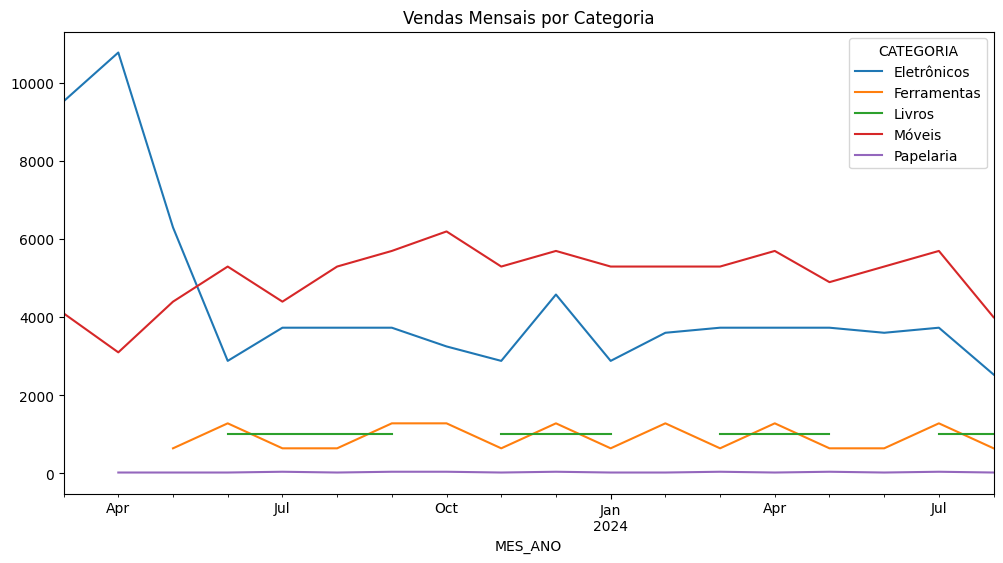

In [30]:
# Tendência mensal por categoria
vendas_mensais_cat = vendas_com_categoria.groupby(['CATEGORIA', 'MES_ANO'])['VALOR ITEM'].sum().unstack(0)
vendas_mensais_cat.plot(kind='line', figsize=(12,6), title='Vendas Mensais por Categoria')

<Figure size 1500x1000 with 0 Axes>

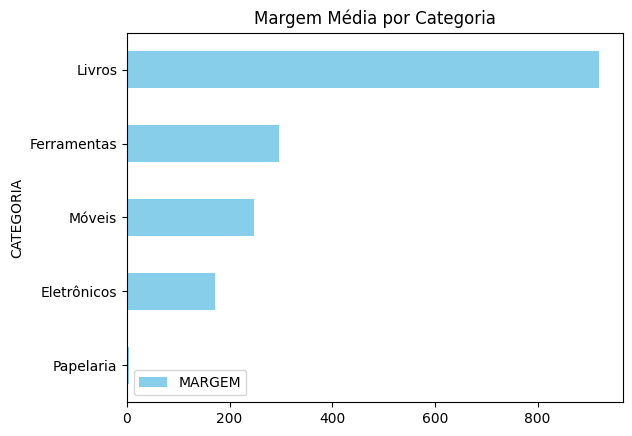

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

# Gráfico 1: Margem por categoria
margem_por_categoria.sort_values('MARGEM').plot.barh(x='CATEGORIA', y='MARGEM', color='skyblue')
plt.title('Margem Média por Categoria')
plt.show()

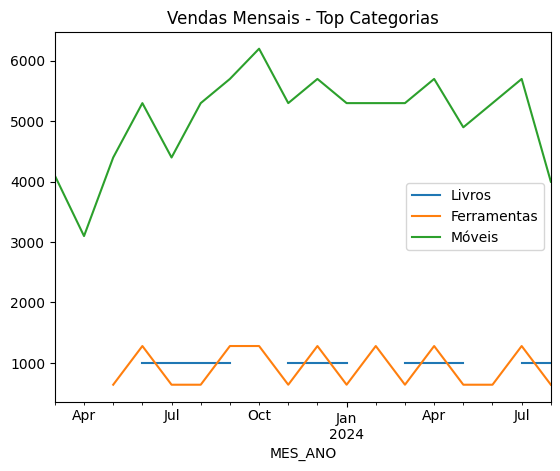

In [38]:
# Gráfico 2: Evolução vendas top categorias
for cat in top_categorias['CATEGORIA']:
    vendas_mensais_cat[cat].plot(label=cat)
plt.legend()
plt.title('Vendas Mensais - Top Categorias')
plt.show()

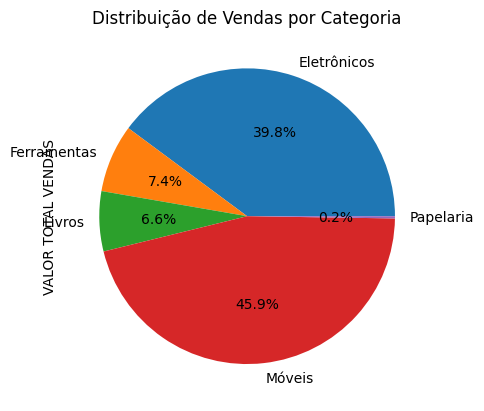

In [39]:
# Gráfico 3: Mix de produtos
valor_por_categoria.set_index('CATEGORIA')['VALOR TOTAL VENDAS'].plot.pie(autopct='%1.1f%%')
plt.title('Distribuição de Vendas por Categoria')
plt.show()

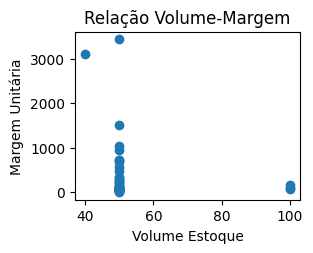

In [40]:
# Gráfico 4: Margem vs Volume
plt.subplot(2,2,4)
plt.scatter(produtos_com_estoque['QTD ESTOQUE'], produtos_com_estoque['VALOR UNITARIO'])
plt.xlabel('Volume Estoque')
plt.ylabel('Margem Unitária')
plt.title('Relação Volume-Margem')
plt.show()